In [1]:
import importlib

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from Utils import paths
from Utils import transformation_utils as t_utils

importlib.reload(paths)
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [2]:
fhr = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/fhr.pickle")
uc = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/uc.pickle")
y = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/y.pickle")

fhr.shape, uc.shape, y.shape

((552, 21620), (552, 21620), (552,))

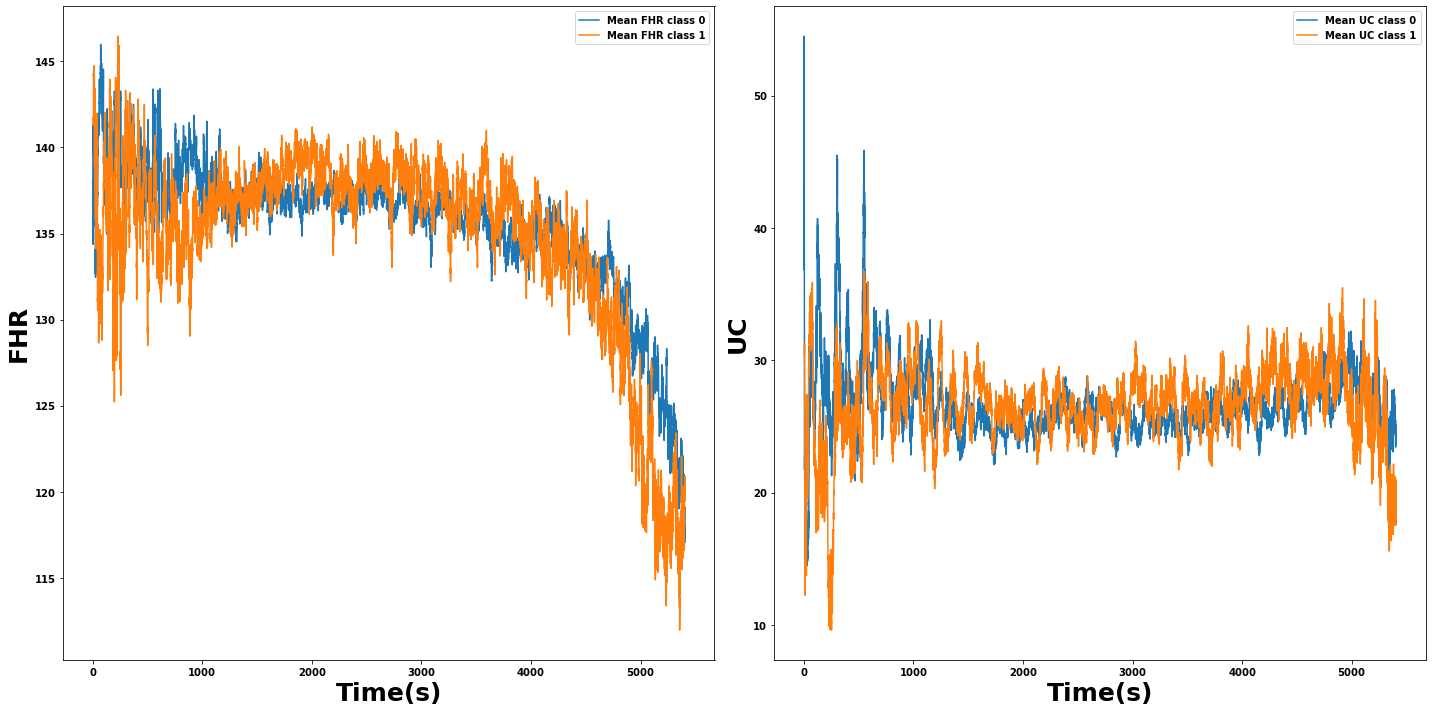

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].plot(fhr[y == 0].mean().index, fhr[y == 0].mean().values, label='Mean FHR class 0')
ax[0].plot(fhr[y == 1].mean().index, fhr[y == 1].mean().values, label='Mean FHR class 1')
ax[1].plot(uc[y == 0].mean().index, uc[y == 0].mean().values, label='Mean UC class 0')
ax[1].plot(uc[y == 1].mean().index, uc[y == 1].mean().values, label='Mean UC class 1')

ax[0].set_xlabel('Time(s)', fontsize=25)
ax[1].set_xlabel('Time(s)', fontsize=25)
ax[0].set_ylabel('FHR', fontsize=25)
ax[1].set_ylabel('UC', fontsize=25)
ax[0].legend()
ax[1].legend()
fig.tight_layout()

In [12]:
cdcor_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(fhr.copy().iterrows(), uc.copy().iterrows()), total=len(uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cdcor_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.dcor)(fhr_signal, uc_signal.shift(lag), 3000)
        for lag in lags
    )
cdcor_df = pd.DataFrame(cdcor_data).T
cdcor_df.columns = lags
cdcor_df

  0%|          | 0/552 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
bad_idx = cdcor_df.index[cdcor_df.isna().sum(axis=1) != 0]
bad_idx

Int64Index([1104, 1119], dtype='int64')

In [ ]:
cdcor_df = cdcor_df.drop(bad_idx)

In [7]:
tt = np.array(lags)

cdcor_0 = cdcor_df.copy()[y == 0]
mean_0 = cdcor_0.mean().values
std_0 = cdcor_0.std().values
max_0 = cdcor_0.max().values
min_0 = cdcor_0.min().values

cdcor_1 = cdcor_df.copy()[y == 1]
mean_1 = cdcor_1.mean().values
std_1 = cdcor_1.std().values
max_1 = cdcor_1.max().values
min_1 = cdcor_1.min().values

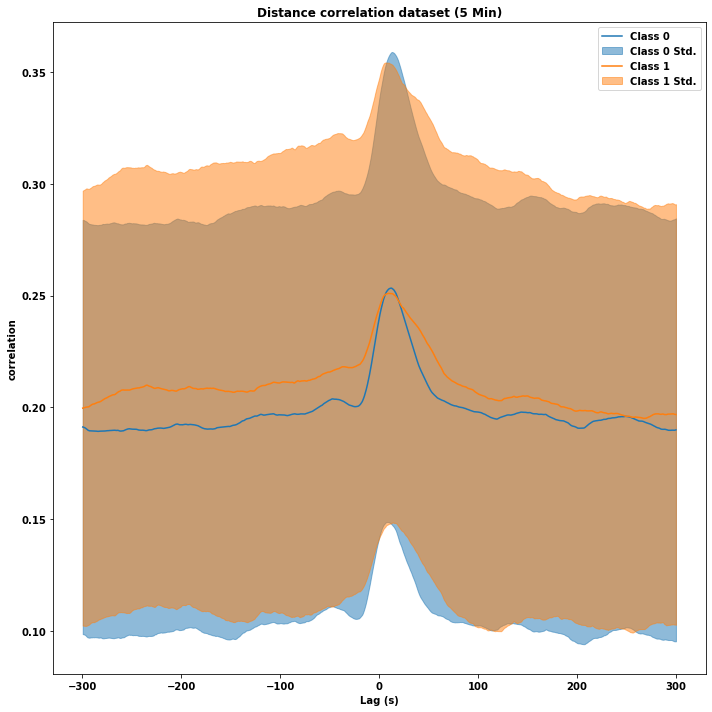

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.plot(tt / 4, mean_0, label='Class 0', color=COLORS[0])
ax.fill_between(tt / 4, mean_0 - std_0, mean_0 + std_0, label='Class 0 Std.', alpha=0.5, color=COLORS[0])

ax.plot(tt / 4, mean_1, label='Class 1', color=COLORS[1])
ax.fill_between(tt / 4, mean_1 - std_1, mean_1 + std_1, label='Class 1 Std.', alpha=0.5, color=COLORS[1])

ax.legend(loc='best')
ax.set_title(f"Distance correlation dataset (5 Min)")
ax.set_ylabel(f"correlation")
ax.set_xlabel("Lag (s)")
fig.tight_layout()

plt.savefig(f"{paths.CDCOR_DATA_PLOTS}/Desc_plot.png")
plt.savefig(f"{paths.CDCOR_DATA_PLOTS}/Desc_plot.pdf")

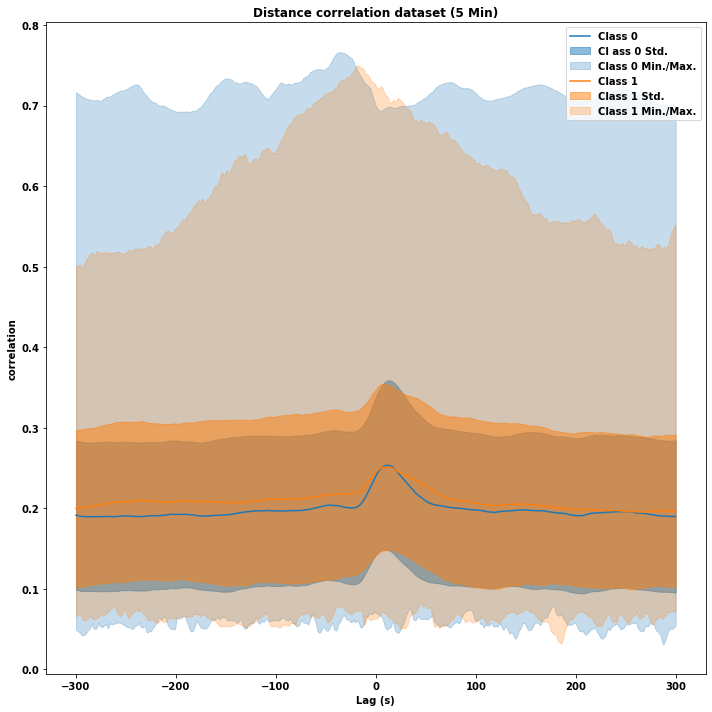

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.plot(tt / 4, mean_0, label='Class 0', color=COLORS[0])
ax.fill_between(tt / 4, mean_0 - std_0, mean_0 + std_0, label='Cl ass 0 Std.', alpha=0.5, color=COLORS[0])
ax.fill_between(tt / 4, min_0, max_0, label='Class 0 Min./Max.', alpha=0.25, color=COLORS[0])

ax.plot(tt / 4, mean_1, label='Class 1', color=COLORS[1])
ax.fill_between(tt / 4, mean_1 - std_1, mean_1 + std_1, label='Class 1 Std.', alpha=0.5, color=COLORS[1])
ax.fill_between(tt / 4, min_1, max_1, label='Class 1 Min./Max.', alpha=0.25, color=COLORS[1])

ax.legend(loc='best')
ax.set_title(f"Distance correlation dataset (5 Min)")
ax.set_ylabel(f"correlation")
ax.set_xlabel("Lag (s)")
fig.tight_layout()

plt.savefig(f"{paths.CDCOR_DATA_PLOTS}/Desc_plot_Mm.png")
plt.savefig(f"{paths.CDCOR_DATA_PLOTS}/Desc_plot_Mm.pdf")

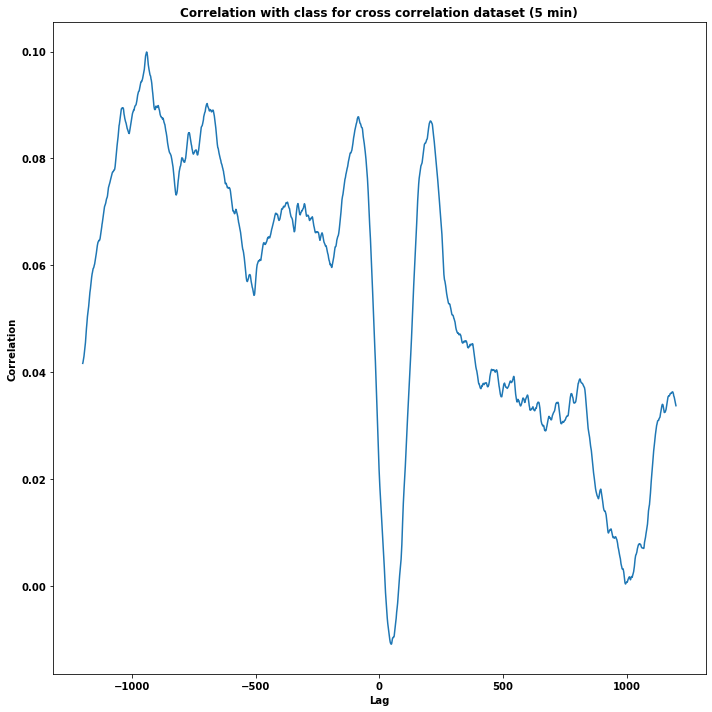

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

cdcor_df.corrwith(y).plot(ax=ax)

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag')
ax.set_title(f'Correlation with class for cross correlation dataset (5 min)')
fig.tight_layout()

plt.savefig(f"{paths.CDCOR_DATA_PLOTS}/Class_correlation.png")
plt.savefig(f"{paths.CDCOR_DATA_PLOTS}/Class_correlation.pdf")

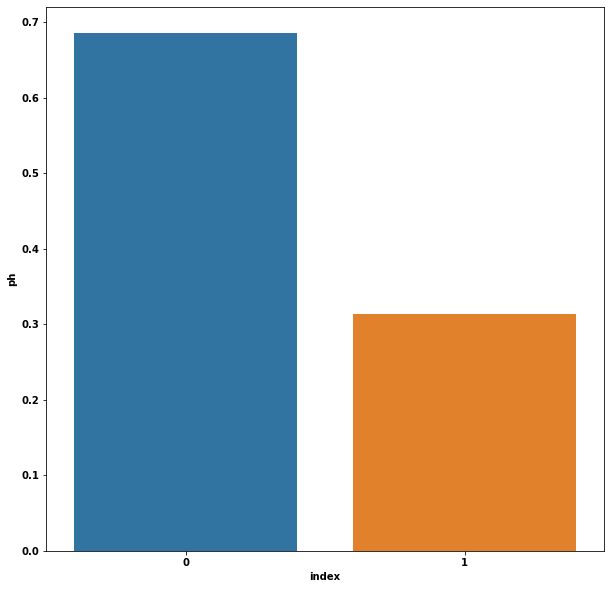

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x='index', y='ph', data=pd.DataFrame(y.value_counts(normalize=True)).reset_index())
plt.savefig(f"{paths.CDCOR_DATA_PLOTS}/Class_Distribution.png")
plt.savefig(f"{paths.CDCOR_DATA_PLOTS}/Class_Distribution.pdf")

In [12]:
cdcor_df['patologico'] = y

In [13]:
cdcor_df.to_csv(f"{paths.CDCOR_DATA_PATH}/cc_dataset.csv")

In [14]:
X = cdcor_df.iloc[:, :-1]
X.to_pickle(f"{paths.CDCOR_DATA_PATH}/X.pickle")
y.to_pickle(f"{paths.CDCOR_DATA_PATH}/y.pickle")
